In [11]:
%pip install tensorflow==2.16.1 keras pandas nltk transformers datasets matplotlib seaborn scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 43.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 44.2 MB/s eta 0:00:0000:0100:01
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [50]:
import pandas as pd

train = pd.read_parquet("go_emotions_train.parquet")
test = pd.read_parquet("go_emotions_test.parquet")

In [51]:
emotions = train.columns[1:].values
emotions

array(['admiration', 'amusement', 'anger', 'annoyance', 'approval',
       'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
       'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
       'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
       'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise',
       'neutral'], dtype=object)

<Axes: title={'center': 'Text length distribution'}, ylabel='Frequency'>

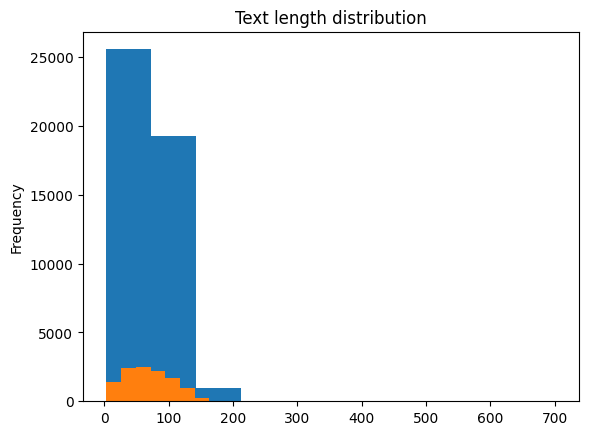

In [52]:
import matplotlib
train["length_text"] = train["text"].apply(len)
train['length_text'].plot(kind='hist', title='Text length distribution')

test["length_text"] = test["text"].apply(len)
test['length_text'].plot(kind='hist', title='Text length distribution')

In [53]:
max_sequence_length = 256

In [54]:
# remove rows with text length > max_sequence_length   
train = train[train["length_text"] <= max_sequence_length]
test = test[test["length_text"] <= max_sequence_length]


<Axes: title={'center': 'Text length distribution'}, ylabel='Frequency'>

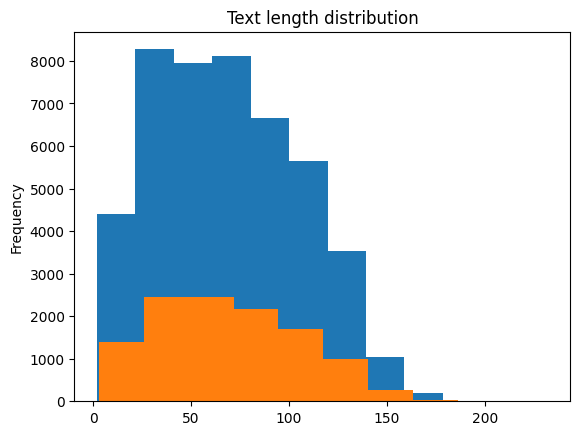

In [55]:
import matplotlib
train["length_text"] = train["text"].apply(len)
train['length_text'].plot(kind='hist', title='Text length distribution')

test["length_text"] = test["text"].apply(len)
test['length_text'].plot(kind='hist', title='Text length distribution')

In [56]:
additional_tokens = [ 
    # smileys
    ":)", ";)", ":P", ":D", ":(", ":'(", ":O", ":/", ":|", ":*", ":@", ">:(", 
    # emojis and their unicode representation
    ":thumbsup:", "👍", ":thumbsdown:", "👎", ":clap:", "👏", ":wave:", "👋", ":pray:", "🙏", 
    ":smile:", "😄", ":grinning:", "😀", ":laughing:", "😆", ":sweat_smile:", "😅", ":rofl:", "🤣", 
    ":blush:", "😊", ":innocent:", "😇", ":wink:", "😉", ":relieved:", "😌", ":heart_eyes:", "😍", 
    ":kissing_heart:", "😘", ":kissing:", "😗", ":kissing_smiling_eyes:", "😙", ":kissing_closed_eyes:", "😚", 
    ":yum:", "😋", ":stuck_out_tongue:", "😛", ":stuck_out_tongue_winking_eye:", "😜", 
    ":stuck_out_tongue_closed_eyes:", "😝", ":money_mouth_face:", "🤑", ":hugs:", "🤗", ":smirk:", "😏", 
    ":unamused:", "😒", ":disappointed:", "😞", ":pensive:", "😔", ":worried:", "😟", ":confused:", "😕", 
    ":persevere:", "😣", ":confounded:", "😖", ":tired_face:", "😫", ":weary:", "😩", ":cry:", "😢", 
    ":sob:", "😭", ":frowning:", "☹️", ":anguished:", "😧", ":fearful:", "😨", ":cold_sweat:", "😰", 
    ":disappointed_relieved:", "😥", ":sweat:", "😓", ":hugging_face:", "🤗", ":thinking:", "🤔", 
    ":shushing_face:", "🤫", ":lying_face:", "🤥", ":no_mouth:", "😶", ":neutral_face:", "😐", 
    ":expressionless:", "😑", ":grimacing:", "😬", ":rolling_eyes:", "🙄", ":hushed:", "😯", 
    ":frowning2:", "☹️", ":anguished:", "😧", ":open_mouth:", "😮", ":astonished:", "😲", 
    ":sleeping:", "😴", ":drooling_face:", "🤤", ":sleepy:", "😪", ":dizzy_face:", "😵", 
    ":zipper_mouth_face:", "🤐", ":nauseated_face:", "🤢", ":sneezing_face:", "🤧", ":mask:", "😷", 
    ":thermometer_face:", "🤒", ":head_bandage:", "🤕", ":smiling_imp:", "😈", ":imp:", "👿", 
    ":japanese_ogre:", "👹", ":japanese_goblin:", "👺", ":skull:", "💀", ":ghost:", "👻", ":alien:", "👽", 
    ":robot:", "🤖", ":poop:", "💩", ":smiley_cat:", "😺", ":smile_cat:", "😸", ":joy_cat:", "😹", 
    ":heart_eyes_cat:", "😻", ":smirk_cat:", "😼", ":kissing_cat:", "😽", ":scream_cat:", "🙀", 
    ":crying_cat_face:", "😿", ":pouting_cat:", "😾", ":raised_hands:", "🙌", ":clap:", "👏", 
    ":wave:", "👋", 
    ]

In [57]:
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


# Tokenize the text data
from transformers import BertTokenizerFast

# Initialize the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Add additional tokens to the tokenizer
tokenizer.add_tokens(additional_tokens)

max_sequence_length = 200

train_sequences = tokenizer(train['text'].tolist(), 
    padding='max_length', truncation=True, 
    max_length=max_sequence_length, return_tensors='np', 
    return_token_type_ids=False, 
    return_attention_mask=False)
train_labels = train[emotions].values
print(len(train_sequences['input_ids']))

test_sequences = tokenizer(test['text'].tolist(),
    padding='max_length', truncation=True, 
    max_length=max_sequence_length, return_tensors='np', 
    return_token_type_ids=False, 
    return_attention_mask=False)
test_labels = test[emotions].values
print(len(test_sequences['input_ids']))

45832
11460


In [58]:
emotion_to_coarse = {
    'admiration': 'positive',
    'amusement': 'positive',
    'anger': 'negative',
    'annoyance': 'negative',
    'approval': 'positive',
    'caring': 'positive',
    'confusion': 'negative',
    'curiosity': 'positive',
    'desire': 'positive',
    'disappointment': 'negative',
    'disapproval': 'negative',
    'disgust': 'negative',
    'embarrassment': 'negative',
    'excitement': 'positive',
    'fear': 'negative',
    'gratitude': 'positive',
    'grief': 'negative',
    'joy': 'positive',
    'love': 'positive',
    'nervousness': 'negative',
    'optimism': 'positive',
    'pride': 'positive',
    'realization': 'positive',
    'relief': 'positive',
    'remorse': 'negative',
    'sadness': 'negative',
    'surprise': 'positive',
    'neutral': 'neutral'
}

# Create lists of emotions for each coarse category
positive_emotions = [emotion for emotion, category in emotion_to_coarse.items() if category == 'positive']
negative_emotions = [emotion for emotion, category in emotion_to_coarse.items() if category == 'negative']
neutral_emotions =  [emotion for emotion, category in emotion_to_coarse.items() if category == 'neutral']

# Sum the values for positive and negative emotions for each row
train['positive_sum'] = train[positive_emotions].sum(axis=1)
train['negative_sum'] = train[negative_emotions].sum(axis=1)
train['neutral_sum'] = train[neutral_emotions].sum(axis=1)

train


,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,realization,relief,remorse,sadness,surprise,neutral,length_text,positive_sum,negative_sum,neutral_sum
45313,Wait isn't that the [NAME] from Fiver?,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,38,3,0,0
8551,Episode IX is apparently about [NAME] going ba...,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,57,3,0,0
15844,I guess the answer is pretty obvious too lol. ...,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,103,2,1,0
44418,Took me long time to figure out there are two ...,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,51,3,0,0
21797,I've seen AOCs ridiculous proposals,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,35,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40930,"The irony here is i agree, but [NAME] is capab...",0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,118,2,1,0
16650,I just saw this on netflix..... Now I'm Watchi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,120,3,0,0
36261,Somebody gettin fired,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,21,2,1,0
35982,So that means the Vikings are the Purple Cobra...,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,50,2,1,0


In [59]:
X_train = train_sequences['input_ids']
y_train = train_labels.astype(np.uint8)
X_test = test_sequences['input_ids']
y_test = test_labels.astype(np.uint8)


print(type(X_train[0]), type(y_train[0]))
print(type(X_train[0][0]), type(y_train[0][0]))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.int64'> <class 'numpy.uint8'>
(45832, 200) (45832, 28)
(11460, 200) (11460, 28)


In [60]:
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay

# Define the learning rate schedule
initial_learning_rate = 1e-4
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [61]:
import tensorflow as tf ; print("Num GPUs Available: ", tf.config.experimental.list_physical_devices("GPU"))


Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Convultional Neural Network (CNN)

In [36]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input, BatchNormalization, LSTM, Bidirectional, Reshape

embedding_dim = 256  # Embedding dimension
max_sequence_length = 256  # Example sequence length, adjust as needed
tokenizer_vocab_size = tokenizer.vocab_size  # Example vocabulary size, adjust as needed

# Number of classes for multi-label classification
num_classes = 28  # Adjust based on your dataset

# Define the CNN model architecture
model = Sequential([
    Input(shape=(max_sequence_length,)),
    Embedding(input_dim=tokenizer_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),  # Embedding layer
    Conv1D(filters=128, kernel_size=32, activation='relu'),  # Conv1D layer
    Dropout(0.2),  # Dropout for regularization
    Dense(2048, activation='relu'),  # Dense layer
    Dense(1512, activation='relu'),  # Dense layer
    Dense(1024, activation='relu'),  # Dense layer
    Conv1D(filters=128, kernel_size=16, activation='relu'),  # Conv1D layer
    Dropout(0.2),  # Dropout for regularization
    Dense(256, activation='relu'),  # Dense layer
    Dense(128, activation='relu'),  # Dense layer
    Conv1D(filters=96, kernel_size=8, activation='relu'),  # Conv1D layer
    Dropout(0.2),  # Dropout for regularization
    Dense(128, activation='relu'),  # Dense layer
    Conv1D(filters=64, kernel_size=5, activation='relu'),  # Conv1D layer
    Conv1D(filters=64, kernel_size=8, activation='relu'),  # Conv1D layer
    GlobalMaxPooling1D(),  # Global max pooling
    Dropout(0.2),  # Dropout for regularization
    Dense(128, activation='relu'),  # Dense layer
    Dropout(0.2),  # Dropout for regularization
    Dense(64, activation='relu'),  # Dense layer
    Dropout(0.2),  # Dropout for regularization
    Dense(num_classes, activation='sigmoid')  # Output layer for multi-label classification
])
# Compile the model with a lower learning rate
initial_lr = 1e-4
model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss='binary_crossentropy',  # Binary cross-entropy loss for multi-label classification
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 256, 256)       │     7,813,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 225, 128)       │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 225, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 225, 2048)      │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 225, 1512)      │     3,098,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 225, 1024)      │     1,549,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 210, 128)       │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 210, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 210, 256)       │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 210, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 203, 96)        │        98,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 203, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 203, 128)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 199, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 192, 64)        │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_10         │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,140,196 (61.57 MB)

 Trainable params: 16,140,196 (61.57 MB)

 Non-trainable params: 0 (0.00 B)

## Transformer Encoder

In [32]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LayerNormalization, Embedding, MultiHeadAttention, GlobalAveragePooling1D
from keras.optimizers import Adam

embedding_dim = 128  # Embedding dimension
max_sequence_length = 256  # Example sequence length, adjust as needed
tokenizer_vocab_size = tokenizer.vocab_size  # Example vocabulary size, adjust as needed
num_classes = 28  # Adjust based on your dataset

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

def build_transformer_model():
    inputs = Input(shape=(200,))
    embedding_layer = Embedding(input_dim=tokenizer_vocab_size, output_dim=embedding_dim, input_length=200)(inputs)
    x = transformer_encoder(embedding_layer, head_size=512, num_heads=2, ff_dim=384, dropout=0.3)
    x = transformer_encoder(x, head_size=512, num_heads=2, ff_dim=384, dropout=0.3)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(768, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(384, activation='relu')(x)
    x = Dense(384, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=3e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Build the model
model = build_transformer_model()

# Summary of the model
model.summary()


/home/sebdg/anaconda3/envs/tf2/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 200, 128)  │  3,906,816 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ embedding_1[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 128)  │    527,488 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 200, 128)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 200, 128)  │          0 │ dropout_13[0][0], │
│                     │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 200, 384)  │     49,536 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 200, 384)  │          0 │ dense_13[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 200, 128)  │     49,280 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 200, 128)  │          0 │ dense_14[0][0],   │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 128)  │    527,488 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 200, 128)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 200, 128)  │          0 │ dropout_16[0][0], │
│                     │                   │            │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 200, 384)  │     49,536 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 200, 384)  │          0 │ dense_15[0][0]  

 Total params: 6,980,508 (26.63 MB)

 Trainable params: 6,980,508 (26.63 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
print(model.predict(X_train[:1]),  y_train[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[0.5017505  0.4956658  0.49901122 0.5079345  0.50248873 0.5025812
  0.496849   0.5006456  0.49792168 0.5045549  0.4986051  0.49776164
  0.50514674 0.4987763  0.5034808  0.50393236 0.5040293  0.49188775
  0.49922585 0.50304615 0.5005385  0.50188583 0.49657714 0.50304556
  0.4988544  0.49942416 0.50121665 0.49927983]] [[1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]]


## Hierarchical Model

In [75]:

from keras.models import Model
from keras.layers import Input, Dense, Embedding, LSTM, Dropout, concatenate, Flatten


input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=tokenizer_vocab_size, output_dim=max_sequence_length)(input_layer)
dropout_layer = Dropout(rate=0.5)(embedding_layer)
flat_layer = Flatten()(dropout_layer)

# Coarse-grained classification layer
coarse_output_layer = Dense(units=3, activation='softmax')(flat_layer)

# Fine-grained classification layer
fine_output_layer = Dense(units=28, activation='relu')( concatenate([coarse_output_layer, flat_layer]))
fine_output_layer = Dropout(rate=0.5)(fine_output_layer)
fine_output_layer = Dense(units=28, activation='sigmoid')(fine_output_layer)


model = Model(inputs=input_layer, outputs=fine_output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 200, 200)  │  6,104,400 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 200, 200)  │          0 │ embedding_11[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 40000)     │          0 │ dropout_40[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 3)         │    120,003 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 40003)     │          0 │ dense_51[0][0],   │
│ (Concatenate)       │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 28)        │  1,120,112 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 28)        │          0 │ dense_52[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 28)        │        812 │ dropout_41[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,345,327 (28.02 MB)

 Trainable params: 7,345,327 (28.02 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [72]:
X_train.shape, y_train.shape

((45832, 200), (45832, 28))

In [69]:
from matplotlib import pyplot as plt    
from keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-4, decay_factor=0.1, step_size=3):
    '''
    Wrapper function to create a step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch / step_size))

    return LearningRateScheduler(schedule)
initial_lr = 1e-4
lr_scheduler = step_decay_schedule(initial_lr=initial_lr, decay_factor=0.9, step_size=3)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=2048, validation_split=.2, callbacks=[lr_scheduler])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


Epoch 1/50


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 28), output.shape=(None, 3)

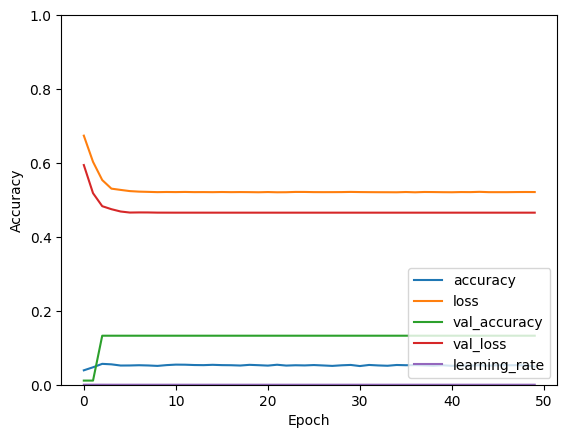

In [68]:

# plot the history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['learning_rate'], label = 'learning_rate')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

